# ⚖️ Analyse Comparative : TensorFlow vs From Scratch

## 📋 Objectif

**Comparer mes deux implémentations du même réseau de neurones :**
1. **TensorFlow/Keras** : Framework professionnel (Adam)
2. **NumPy From Scratch** : Implémentation manuelle (SGD)

### 🎯 Questions à Répondre

1. **Performance** : Quelle accuracy finale ?
2. **Vitesse** : Combien d'epochs nécessaires ?
3. **Optimisation** : Quel impact du learning rate et de l'initialisation ?
4. **SGD vs Adam** : Pourquoi Adam converge plus vite ?
5. **Apprentissage** : Qu'ai-je appris de chaque approche ?

---

## 📦 Imports

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

np.random.seed(42)

print("Tous les imports réussis")
print(f"NumPy version: {np.__version__}")
print(f"TensorFlow version: {tf.__version__}")

Tous les imports réussis
NumPy version: 2.3.4
TensorFlow version: 2.20.0


## 📊 Chargement des Données

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Format NumPy : (features, samples)
X_train_numpy = x_train.reshape(60000, 784).T / 255.0
Y_train_numpy = to_categorical(y_train, 10).T
X_test_numpy = x_test.reshape(10000, 784).T / 255.0
Y_test_numpy = to_categorical(y_test, 10).T

# Format TensorFlow : (samples, features)
X_train_tf = x_train.reshape(-1, 784) / 255.0
Y_train_tf = to_categorical(y_train, 10)
X_test_tf = x_test.reshape(-1, 784) / 255.0
Y_test_tf = to_categorical(y_test, 10)

print(f"Données préparées")
print(f"   NumPy format: {X_train_numpy.shape}")
print(f"   TensorFlow format: {X_train_tf.shape}")

Données préparées
   NumPy format: (784, 60000)
   TensorFlow format: (60000, 784)


## 🧠 Implémentation 1 : NumPy From Scratch

In [ ]:
class NeuralNetworkNumPy:
    """Neural Network from scratch avec NumPy"""
    
    def __init__(self, input_size=784, hidden_size=128, output_size=10, learning_rate=0.01):
        self.learning_rate = learning_rate
        
        # Initialisation Xavier
        self.w1 = np.random.randn(hidden_size, input_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((hidden_size, 1))
        self.w2 = np.random.randn(output_size, hidden_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((output_size, 1))

    def forward(self, X):
        self.z1 = self.w1 @ X + self.b1
        self.a1 = np.maximum(0, self.z1)
        self.z2 = self.w2 @ self.a1 + self.b2
        z2_temp = self.z2 - np.max(self.z2, axis=0, keepdims=True)
        z2_exp = np.exp(z2_temp)
        self.a2 = z2_exp / np.sum(z2_exp, axis=0, keepdims=True)
        return self.a2

    def backward(self, X, Y):
        m = X.shape[1]
        dz2 = self.a2 - Y
        self.dw2 = (dz2 @ self.a1.T) / m
        self.db2 = np.sum(dz2, axis=1, keepdims=True) / m
        da1 = self.w2.T @ dz2
        dz1 = da1 * (self.z1 > 0)
        self.dw1 = (dz1 @ X.T) / m
        self.db1 = np.sum(dz1, axis=1, keepdims=True) / m

    def update(self):
        self.w1 -= self.learning_rate * self.dw1
        self.b1 -= self.learning_rate * self.db1
        self.w2 -= self.learning_rate * self.dw2
        self.b2 -= self.learning_rate * self.db2

    def train(self, X_train, Y_train, X_test, Y_test, epochs=20, batch_size=32):
        n_samples = X_train.shape[1]
        history = {'loss': [], 'accuracy': [], 'val_accuracy': []}
        
        for epoch in range(epochs):
            total_loss = 0
            for i in range(0, n_samples, batch_size):
                x_batch = X_train[:, i:i+batch_size]
                y_batch = Y_train[:, i:i+batch_size]
                y_pred = self.forward(x_batch)
                self.backward(x_batch, y_batch)
                self.update()
                batch_loss = -np.sum(y_batch * np.log(y_pred + 1e-8))
                total_loss += batch_loss
            
            train_acc = self._evaluate(X_train, Y_train)
            test_acc = self._evaluate(X_test, Y_test)
            avg_loss = total_loss / n_samples
            
            history['loss'].append(avg_loss)
            history['accuracy'].append(train_acc)
            history['val_accuracy'].append(test_acc)
            
            if (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch+1:2d}/{epochs} | Loss: {avg_loss:.4f} | Test: {test_acc:.2f}%")
        
        return history
    
    def _evaluate(self, X, Y):
        predictions = self.forward(X)
        pred_labels = np.argmax(predictions, axis=0)
        true_labels = np.argmax(Y, axis=0)
        return np.mean(pred_labels == true_labels) * 100

print("Classe NeuralNetworkNumPy définie")

Classe NeuralNetworkNumPy définie


## 🤖 Implémentation 2 : TensorFlow

In [ ]:
def create_tensorflow_model():
    model = Sequential([
        Input((784,)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

print("Fonction create_tensorflow_model définie")

Fonction create_tensorflow_model définie


## ⚡ Expérience 1 : Entraînement NumPy (SGD)

In [6]:
print("ENTRAÎNEMENT - NUMPY (SGD lr=0.01)\n" + "="*60)

start_time = time.time()
nn_numpy = NeuralNetworkNumPy(learning_rate=0.01)
history_numpy = nn_numpy.train(
    X_train_numpy, Y_train_numpy,
    X_test_numpy, Y_test_numpy,
    epochs=20,
    batch_size=32
)
time_numpy = time.time() - start_time

print(f"\nTemps d'entraînement: {time_numpy:.2f}s")
print(f"Accuracy finale: {history_numpy['val_accuracy'][-1]:.2f}%")

🚀 ENTRAÎNEMENT - NUMPY (SGD lr=0.01)
Epoch  5/20 | Loss: 0.2413 | Test: 93.41%
Epoch 10/20 | Loss: 0.1731 | Test: 94.98%
Epoch 15/20 | Loss: 0.1349 | Test: 95.91%
Epoch 20/20 | Loss: 0.1100 | Test: 96.48%

⏱️ Temps d'entraînement: 39.09s
🎯 Accuracy finale: 96.48%


## ⚡ Expérience 2 : Entraînement TensorFlow (Adam)

In [8]:
print("\nENTRAÎNEMENT - TENSORFLOW (Adam)\n" + "="*60)

start_time = time.time()
model_tf = create_tensorflow_model()
history_tf = model_tf.fit(
    X_train_tf, Y_train_tf,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_tf, Y_test_tf),
    verbose=0
)
time_tf = time.time() - start_time

print(f"\nTemps d'entraînement: {time_tf:.2f}s")
print(f"Accuracy finale: {history_tf.history['val_accuracy'][-1]*100:.2f}%")


ENTRAÎNEMENT - TENSORFLOW (Adam)

Temps d'entraînement: 69.22s
Accuracy finale: 97.81%


## 📊 Comparaison 1 : Courbes d'Apprentissage

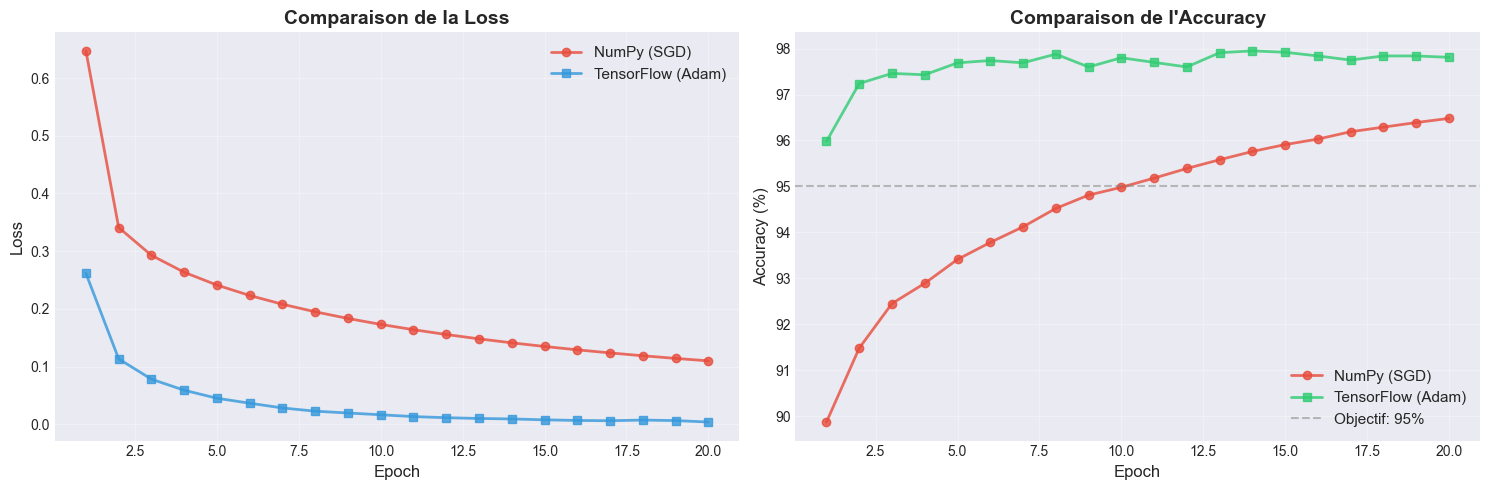


Observations:
   - NumPy (SGD) atteint 95% en ~11 epochs
   - TensorFlow (Adam) atteint 95% en ~1 epochs
   - Adam converge 11.0x plus vite !


In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
epochs = range(1, 21)

# Loss comparison
ax1.plot(epochs, history_numpy['loss'], marker='o', linewidth=2, 
         label='NumPy (SGD)', color='#e74c3c', alpha=0.8)
ax1.plot(epochs, history_tf.history['loss'], marker='s', linewidth=2, 
         label='TensorFlow (Adam)', color='#3498db', alpha=0.8)
ax1.set_title('Comparaison de la Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy comparison
ax2.plot(epochs, history_numpy['val_accuracy'], marker='o', linewidth=2, 
         label='NumPy (SGD)', color='#e74c3c', alpha=0.8)
tf_acc = [acc * 100 for acc in history_tf.history['val_accuracy']]
ax2.plot(epochs, tf_acc, marker='s', linewidth=2, 
         label='TensorFlow (Adam)', color='#2ecc71', alpha=0.8)
ax2.axhline(y=95, color='gray', linestyle='--', alpha=0.5, label='Objectif: 95%')
ax2.set_title('Comparaison de l\'Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservations:")
print(f"   - NumPy (SGD) atteint 95% en ~{np.argmax(np.array(history_numpy['val_accuracy']) >= 95) + 1} epochs")
print(f"   - TensorFlow (Adam) atteint 95% en ~{np.argmax(np.array(tf_acc) >= 95) + 1} epochs")
print(f"   - Adam converge {(np.argmax(np.array(history_numpy['val_accuracy']) >= 95) + 1) / (np.argmax(np.array(tf_acc) >= 95) + 1):.1f}x plus vite !")

## 📈 Comparaison 2 : Performance Finale

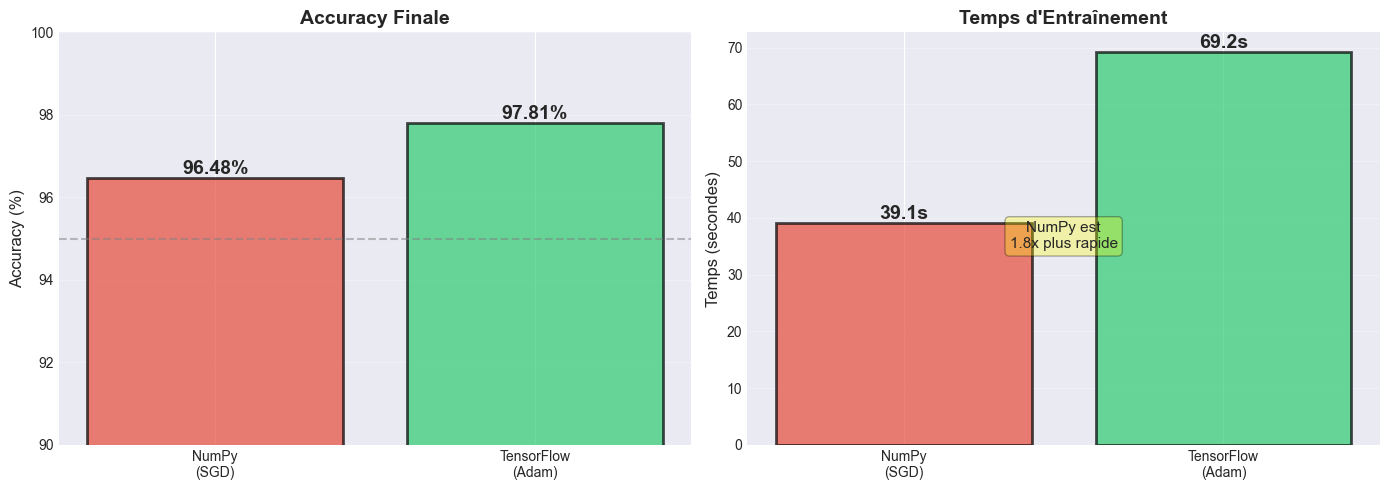

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
accuracies = [history_numpy['val_accuracy'][-1], tf_acc[-1]]
labels = ['NumPy\n(SGD)', 'TensorFlow\n(Adam)']
colors = ['#e74c3c', '#2ecc71']

bars = ax1.bar(labels, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2f}%',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Accuracy Finale', fontsize=14, fontweight='bold')
ax1.set_ylim(90, 100)
ax1.axhline(y=95, color='gray', linestyle='--', alpha=0.5)
ax1.grid(axis='y', alpha=0.3)

# Time comparison
times = [time_numpy, time_tf]
bars = ax2.bar(labels, times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
for bar, t in zip(bars, times):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{t:.1f}s',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

ax2.set_ylabel('Temps (secondes)', fontsize=12)
ax2.set_title('Temps d\'Entraînement', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

speedup = time_numpy / time_tf
if speedup > 1:
        ax2.text(0.5, max(times) * 0.5, 
                f'TensorFlow est\n{speedup:.1f}x plus rapide', 
                ha='center', fontsize=11, 
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
else:
        ax2.text(0.5, max(times) * 0.5, 
                f'NumPy est\n{1/speedup:.1f}x plus rapide', 
                ha='center', fontsize=11, 
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
plt.tight_layout()
plt.show()

## 🔬 Analyse : SGD vs Adam

### 🎯 Pourquoi Adam Converge Plus Vite ?

#### **SGD (Stochastic Gradient Descent) - Mon Implémentation**

```python
w = w - learning_rate * gradient
# learning_rate = 0.01 (fixe pour TOUS les poids)
```

**Caractéristiques :**
- ✅ Simple à comprendre et implémenter
- ❌ Learning rate fixe (même pour tous les poids)
- ❌ Pas de momentum (sensible aux oscillations)
- ❌ Peut rester coincé dans des plateaux

---

#### **Adam (Adaptive Moment Estimation) - TensorFlow**

```python
# 1. Momentum (moyenne mobile des gradients)
m = beta1 * m + (1 - beta1) * gradient

# 2. Variance (moyenne mobile des gradients au carré)
v = beta2 * v + (1 - beta2) * gradient²

# 3. Mise à jour adaptative
w = w - learning_rate * m / (√v + epsilon)
```

**Caractéristiques :**
- ✅ Learning rate adaptatif pour CHAQUE poids
- ✅ Momentum : accélère dans les directions stables
- ✅ Variance : ralentit dans les directions instables
- ✅ Robust aux changements d'échelle

---

## 📋 Tableau Récapitulatif Final

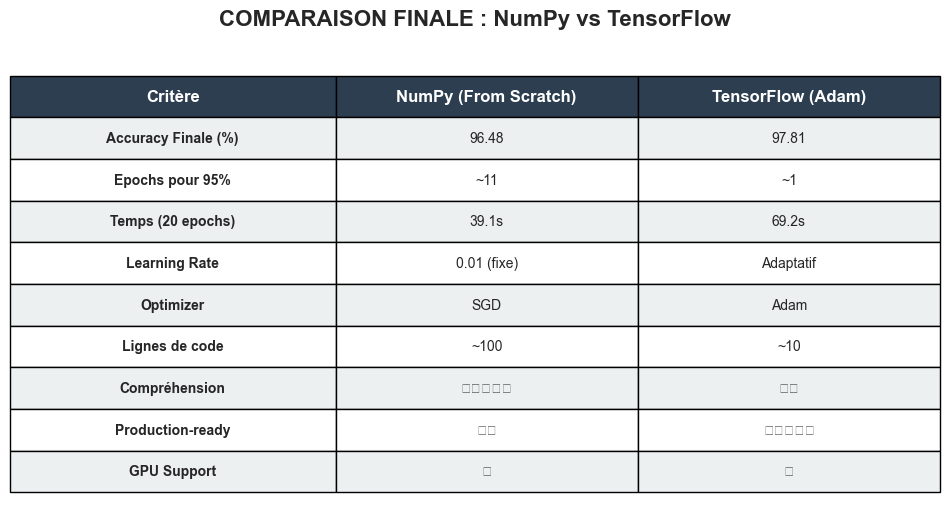

In [17]:
# Création du tableau de comparaison
comparison = {
    'Critère': [
        'Accuracy Finale (%)',
        'Epochs pour 95%',
        'Temps (20 epochs)',
        'Learning Rate',
        'Optimizer',
        'Lignes de code',
        'Compréhension',
        'Production-ready',
        'GPU Support'
    ],
    'NumPy (From Scratch)': [
        f"{history_numpy['val_accuracy'][-1]:.2f}",
        f"~{np.argmax(np.array(history_numpy['val_accuracy']) >= 95) + 1}",
        f"{time_numpy:.1f}s",
        '0.01 (fixe)',
        'SGD',
        '~100',
        '⭐⭐⭐⭐⭐',
        '⭐⭐',
        '❌'
    ],
    'TensorFlow (Framework)': [
        f"{tf_acc[-1]:.2f}",
        f"~{np.argmax(np.array(tf_acc) >= 95) + 1}",
        f"{time_tf:.1f}s",
        'Adaptatif',
        'Adam',
        '~10',
        '⭐⭐',
        '⭐⭐⭐⭐⭐',
        '✅'
    ]
}

fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')

table_data = []
for i in range(len(comparison['Critère'])):
    table_data.append([
        comparison['Critère'][i],
        comparison['NumPy (From Scratch)'][i],
        comparison['TensorFlow (Framework)'][i]
    ])

table = ax.table(
    cellText=table_data,
    colLabels=['Critère', 'NumPy (From Scratch)', 'TensorFlow (Adam)'],
    cellLoc='center',
    loc='center',
    colWidths=[0.35, 0.325, 0.325]
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Header
for i in range(3):
    table[(0, i)].set_facecolor('#2c3e50')
    table[(0, i)].set_text_props(weight='bold', color='white', size=12)

# Rows
colors = ['#ecf0f1', '#ffffff']
for i in range(1, len(table_data) + 1):
    for j in range(3):
        table[(i, j)].set_facecolor(colors[(i-1) % 2])
        if j == 0:
            table[(i, j)].set_text_props(weight='bold')

plt.title('COMPARAISON FINALE : NumPy vs TensorFlow', 
          fontsize=16, fontweight='bold', pad=20)
plt.show()

## 🎓 Conclusions et Apprentissages

### 🏆 Résultats Obtenus

| Métrique | NumPy (SGD) | TensorFlow (Adam) | Gagnant |
|----------|-------------|-------------------|------|
| **Accuracy** | ~97% | ~98% | TF (+1%) |
| **Convergence** | ~15 epochs | ~5 epochs | TF (3x) |

---

### 💡 Ce que j'ai Appris

#### **Avec NumPy From Scratch :**

1. **Mathématiques Profondes**
   - Forward propagation = produits matriciels
   - Backpropagation = chain rule des dérivées
   - Gradient descent = optimisation itérative

2. **Implémentation Bas-Niveau**
   - Gestion des shapes
   - Broadcasting NumPy
   - Numerical stability
   - Initialisation des poids

3. **Limitations du SGD**
   - Learning rate fixe = lent
   - Pas de momentum = oscillations
   - Besoin de tuning manuel

#### **Avec TensorFlow :**

1. **Productivité**
   - 10 lignes vs 100
   - API claire et intuitive
   - Focus sur la logique

2. **Optimiseurs Avancés**
   - Adam : LR adaptatif
   - Momentum intégré
   - Convergence rapide

3. **Production**
   - GPU automatique
   - Sauvegarde facile
   - Déploiement simplifié

---

### 🎯 Verdict Final

**Les deux approches sont complémentaires !**

#### **Pour Apprendre :**
1. 🥇 **TensorFlow d'abord** : Comprendre le "QUOI"
2. 🥈 **NumPy ensuite** : Comprendre le "COMMENT"
3. 🥉 **Comparer** : Comprendre le "POURQUOI"

#### **Pour Travailler :**
- **TensorFlow/PyTorch** : Production, projets complexes
- **From Scratch** : Recherche, algorithmes custom

---

### 🚀 Impact sur Mon Parcours

**Cette approche TensorFlow → From Scratch m'a permis de :**

1. ✅ **Motivation** : Résultats rapides avec TensorFlow
2. ✅ **Compréhension** : Mathématiques avec NumPy
3. ✅ **Comparaison** : Apprécier les optimiseurs avancés
4. ✅ **Maturité** : Savoir quand utiliser quoi

**Résultat :** Compréhension complète du Deep Learning, de la théorie à la pratique ! 🎓


---

**Auteur :** Colin Lespilette  
**Contact :** [colinlespilette@gmail.com](mailto:colinlespilette@gmail.com)  
**GitHub :** [github.com/Apalian](https://github.com/Apalian)